# Tutorial Part 2: Coix API

Inference combinators [(Stites and Zimmermann et al., 2021)](https://arxiv.org/abs/2103.00668) are a set of program transformations for compositional inference and a corresponding small domain specific language (DSL), which describes how these transformations can be composed. We refer to this DSL as *inference language*. Applying inference combinators does not alter the model, which can be defined in an independent *modeling language* -- there only needs to be a common interface between modeling and inference language. Hence, in principle infernce combinators can be implemented on top of any probabilistic *modelling language*. In this tutorial we will use python + numpyro as our probabilistic modeling language but coix also implements backend for pyro and oryx. 

Inference combinators comprise four basic program transformations (combinators), `extend`, `resample`, `compose` and `propose`, which can be combined according to the following grammar (in [Backus–Naur form](https://en.wikipedia.org/wiki/Backus%E2%80%93Naur_form), non-terminals in bold text):

\begin{align}
\textbf{k} &::= \mathrm{primitive\ program\ without\ observe\ statements}
\\
\textbf{f} &::= k \mid \mathrm{primitive\ program\ with\ observe\ statements} && (\text{primitive programs})
\\
\textbf{p} &::= \textbf{f} \mid \mathrm{extend}(\textbf{p}, \textbf{k}) && (\text{target programs})
\\
\textbf{q} &::= \textbf{p} \mid \mathrm{propose}(\textbf{p}, \textbf{q}) \mid \mathrm{resample}(\textbf{q}) \mid \mathrm{compose}(\textbf{q}, \textbf{q}) && (\text{inference programs})
\end{align}

The grammar defines the following program taxonomy:
\begin{align}
S_\mathrm{kernel\ program} \subset
S_\mathrm{primitive\ program} \subset
S_\mathrm{target\ program} \subset
S_\mathrm{inference\ program}
\end{align}

Kernel programs (primitive programs without observe statements) are the most specialized programs, followed by primitive programs and target programs, while inference programs are the most general. 
However, as we will see, this generality comes with restriction in the ways we can combined these programs in oder to guarantee the validity of the composed program.

In the following we walk through basic principles underlying infernce combinators, the application of each combinator, and their composition. The emphasis is on understanding and applying the main concepts, for an in depth technical discussion we refer to [Stites and Zimmermann et al.](https://arxiv.org/abs/2103.00668).

### Primitive Programs
A primitive program is any probabilitic program in the modelling language (e.g. pyro, numpyro, or oryx depending on the backend we chose) which is not constructed by an inference combinator. Let's have a look at the following primitive program:

In [1]:
# !pip install numpyro coix

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro.handlers import seed, trace
import numpyro.distributions as dist
import coix

coix.set_backend(
    "coix.numpyro"
)  # Setting the backend depending on the modeling language, here python + numpyro
from coix import traced_evaluate

log_phi = lambda x: -0.5 * ((x - 1.0) / 0.1) ** 2


def f():
  x = numpyro.sample("x", dist.Normal(0.0, 1.0))
  numpyro.factor("phi_x", log_phi(x))
  return (x,)

We can evaluate the program and have a look at it's trace, the data structure that keeps track of all the random choices made by a program.

In [3]:
from pprint import pprint

f_seeded = seed(rng_seed=0)(f)
f_out = f_seeded()
f_trace = trace(f_seeded).get_trace()
print(f_out)
pprint(f_trace)

(Array(-1.2515389, dtype=float32),)
OrderedDict([('x',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.continuous.Normal object at 0x28943b950>,
               'infer': {},
               'intermediates': [],
               'is_observed': False,
               'kwargs': {'rng_key': Array([1278412471, 2182328957], dtype=uint32),
                          'sample_shape': ()},
               'name': 'x',
               'scale': None,
               'type': 'sample',
               'value': Array(-0.58665055, dtype=float32)}),
             ('phi_x',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.distribution.Unit object at 0x28945c7d0>,
               'infer': {'is_auxiliary': True},
               'intermediates': [],
               'is_observed': True,
               'kwargs': {'rng_key': None, 'sample_shape': ()},
               'name': 'phi_x',
               'sc

We can see that the program trace has two nodes: (1) a node corresponding to the random variable $x$ and (2) a node corresponding to the factor node $\phi_x$ which are both of type `sample`. The factor node `phi_x` is *observerd*  while the random variable node `x` is not.
We will see that whether a node is *observed* or *unobserved* plays an important role in the semantics of a program, as it changes the density the program denotes. 
As mentioned above, we call a promitive program without any observe statements a *kernel program*.
In combinators each primitive program denotes two densities:
1. a **prior density**, which is defined as the joint density over all unobserverd variables in the program
2. an **unnormalized target density**, which is defined as the joint density over all variables in the program

To get a better understanding of these densities and why their distinction is important, let's visualize these densities for the primitive program `f` that we defined above:
1. The prior density is given by the denstity of the normal distribution
2. The unnormalized target denstity given by the product of the densities of the normal distribution and the factor node

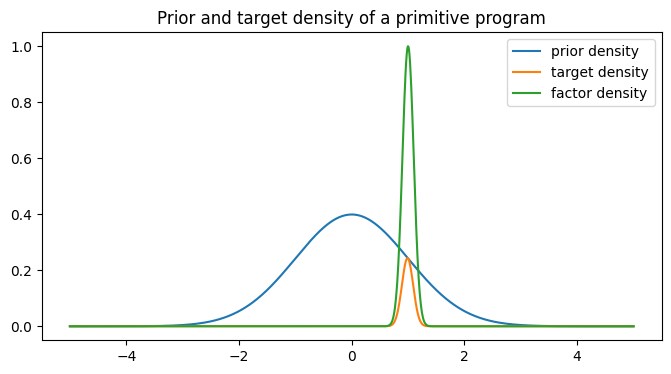

In [4]:
import numpy as np
import matplotlib.pyplot as plt

log_prior_density = lambda x: dist.Normal(0, 1).log_prob(x)
log_target_density = lambda x: log_prior_density(x) + log_phi(x)
xrange_prior = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.title("Prior and target density of a primitive program")
plt.plot(
    xrange_prior, np.exp(log_prior_density(xrange_prior)), label="prior density"
)
plt.plot(
    xrange_prior,
    np.exp(log_target_density(xrange_prior)),
    label="target density",
)
plt.plot(xrange_prior, np.exp(log_phi(xrange_prior)), label="factor density")
plt.legend();

<!-- ### Evaluating programs in Combinators -->
While it is possible to evaluate programs using numpyro effect handlers, coix implements it's own evaluation handler, `traced_evaluate`, which uses numpyro's `seed` and `trace` handlers under the hood. It exposes the return value of the program, a simplified trace, and an additional `metrics` dictionary, which stores different evaluation metrics that are accumulated during the execution of the program.
Most importantly, the metrics dictionary contains the log-importance weights corresponding to the execution traces of the program. For primitive programs the log weight is defined as the sum of the log probabilities of all observed random variables in the trace. Hence, the log weight is precisely the difference between the log-prior density and the log-target density of a program. Let's verify this for our example program `f`:

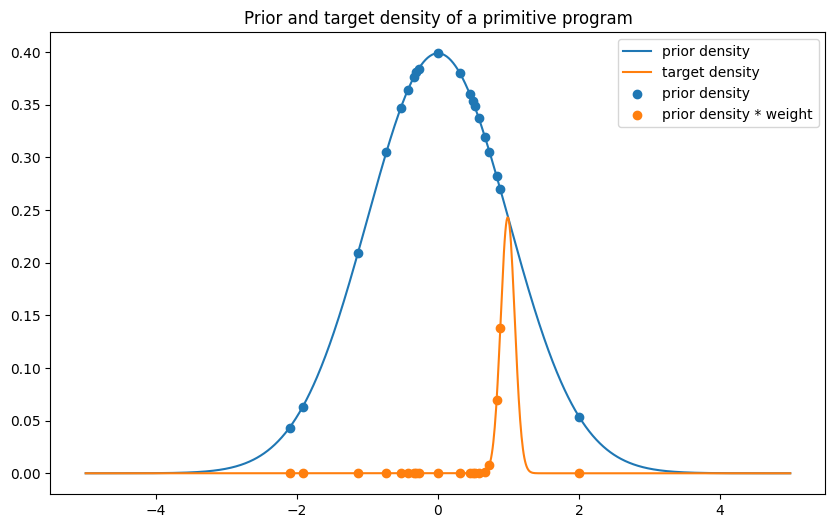

In [5]:
_, f_batch_trace, f_batch_metrics = traced_evaluate(
    numpyro.plate("particle_plate", 20)(f), seed=0
)()

plt.figure(figsize=(10, 6))
plt.title("Prior and target density of a primitive program")
plt.plot(
    xrange_prior, np.exp(log_prior_density(xrange_prior)), label="prior density"
)
plt.plot(
    xrange_prior,
    np.exp(log_target_density(xrange_prior)),
    label="target density",
)

plt.scatter(
    f_batch_trace["x"]["value"],
    np.exp(f_batch_trace["x"]["log_prob"]),
    label="prior density",
)
plt.scatter(
    f_batch_trace["x"]["value"],
    np.exp(f_batch_trace["x"]["log_prob"] + f_batch_metrics["log_weight"]),
    label="prior density * weight",
)
plt.legend();

### Proper Weighting

The above observation suggests that we can use the weighted samples $(x, w)$ produced by a primitive program to approximate expectations w.r.t. its target density up to a normalization constant $Z$. 
We refer to this property as *proper weighting*. We can generalize this notion of proper weighting to programs that define more than one variable, by weighting execution traces $\tau$ instead, which track all random choices of a particular program evaluation.


**Definition (Properly weighted evaluation)**:
We say *the evaluation of the program $\tau, w \leftarrow f$ is properly weighted w.r.t. its unnormalized target density $\gamma_{target} = Z p_{target}$*, if for all measurable function $h$,

\begin{align}
\mathbb{E}_{\tau, w}\left[ w \cdot h (\tau) \right] 
=
Z \cdot \mathbb{E}_{p_{target}} \left[ h(\tau) \right]
.
\end{align}

Indeed, with the definition of the target density and weight of a primitive program above, we can show that all primitive programs are properly weighted w.r.t. their target densities (see [Stites and Zimmermann et al., 2021](https://arxiv.org/abs/2103.00668)). 

As this property holds for any measureable function $h$, it must also hold for $h(\tau) = 1$. In this case the above equation reduces to $\mathbb{E}_{\tau, w}\left[ w \right]  = Z$, meaning that the expected weight must equal the normalizing constant of the target density. 

Let's test this for our example program `f`. Fortunately, for our example, we can compute the normalization constant for the target density of `f` analytically by noticing that the factor $\phi_x$ is just an unnormalized normal density. This allows us to do some math to derive the normalizing constant $Z_{target}$ (for the purpose of this tutorial the math can safely be skipped):

\begin{align}
Z_{target} = \sqrt{2\pi\sigma_{target}^2} \cdot Z_{\phi}
,&&
Z_{\phi} = \sqrt{2\pi\sigma_{\phi}^2}
,&&
\sigma^2_{target} = \frac{1}{\frac{1}{\sigma_x^2} + \frac{1}{\sigma_{\phi}^2}}
.
\end{align}


If the the samples we obtained from running `f` are propoerly weighted, we should be able to compute an estimate of the normalizing constant of the target density of `f` by simply averaging them.

In [6]:
var_prior = 1.0
var_factor = 0.1**2
var_target = 1 / (1 / var_prior + 1 / var_factor)
Z_target = np.sqrt(2 * np.pi * var_target) * jnp.sqrt(2 * jnp.pi * var_factor)
normalized_log_target_density = lambda x: log_target_density(x) - jnp.log(
    Z_target
)

_, f_batch_trace, f_batch_metrics = traced_evaluate(
    numpyro.plate("particle_plate", 10000)(f), seed=0
)()
approx_target_sampels = f_batch_trace["x"]["value"]
weights = jnp.exp(f_batch_metrics["log_weight"])

print("Normalizing constant:", Z_target)
print("Estimated normalizing constant:", weights.mean())

Normalizing constant: 0.062520035
Estimated normalizing constant: 0.06102728


A convinient way to visially check if the weighted samples we generated approximate out target density well is to simply plot a sample histogram.

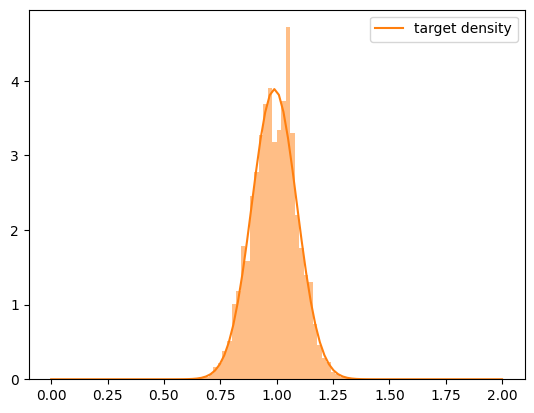

In [7]:
xrange_target = np.linspace(0, 2, 100)
plt.plot(
    xrange_target,
    np.exp(normalized_log_target_density(xrange_target)),
    label="target density",
    color="C1",
)
_ = plt.hist(
    approx_target_sampels,
    weights=weights,
    density=True,
    bins=100,
    range=(xrange_target[0], xrange_target[-1]),
    color="C1",
    alpha=0.5,
)
plt.legend();

### Target Programs
Now that we understand the significance of the densities denoted by a program, as well as the role of the importance weight associated with a program evaluation, we can talk about target programs. The grammar defines a target programs as

\begin{align}
p &::= f \mid \mathrm{extend}(p, k)
\end{align}

In other words, a target program is either
1. primitive program or 
2. a program produced by an `extend` combinator

We already talked about primitive programs and the prior- and target-density they denote, so let's have a closer look at *extended programs*. The `extend` combinator is used to produce a program that extends the prior and target density of a  target program `p` by introducing *auxiliary variables*. When an extended program is executed it first executes the target program `p` and consecutively runs the kernel program `k` on the output of `p`.
The prior density and of the extended program `extend(p, k)` is defined as the product of the prior densities of the input programs, `p` and `k`. Similarly the target density of `extend(p, k)` is defined as the product the target densities of the input programs.

Importantly, `extend(p, k)` is only valid if `k` is a kernel program. Moreover, it does not check if `k` does contains any illegal observe statements, so it is our responsibility to make use we are passing a kernel program.

Let's see what happens when we extend the primitive program `f` with a kernel program:

In [8]:
def k(x):
  y = numpyro.sample("y", dist.Normal(2 * x + 3, 0.5))
  return (y,)


p_ext = coix.extend(f, k)
log_extend_density = lambda x, y: dist.Normal(2 * x + 3, 0.5).log_prob(y)
log_extended_target_density = lambda x, y: log_target_density(
    x
) + log_extend_density(x, y)
log_extended_prior_density = lambda x, y: log_prior_density(
    x
) + log_extend_density(x, y)

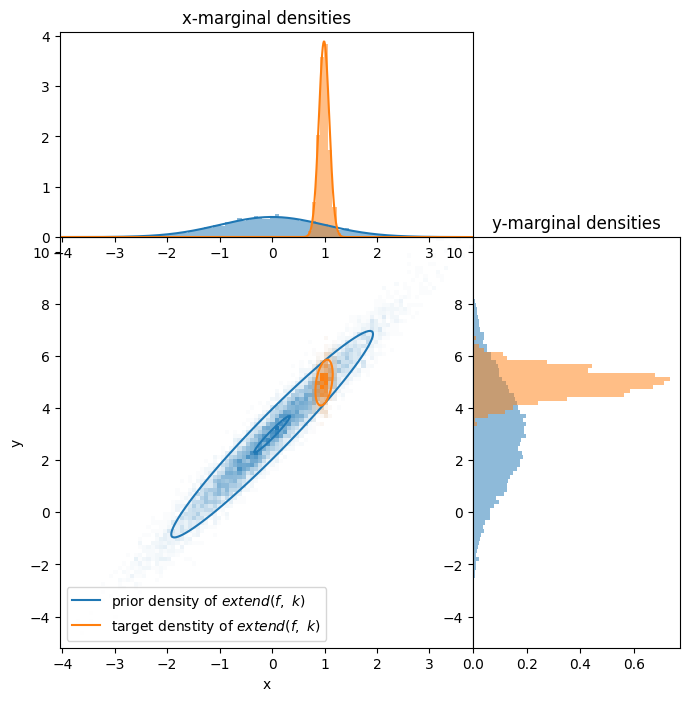

In [9]:
# A bunch of plotting code that can be ignored...
from matplotlib import colors, lines, gridspec


def plot_extended_density_samples(
    p, name_x="x", name_y="y", color1="C0", color2="C1"
):
  p_batch = numpyro.plate("particle_plate", 10000)(p)
  out, trace, metrics = traced_evaluate(p_batch, seed=0)()
  out_rs, trace_rs, metrics_rs = traced_evaluate(
      coix.resample(p_batch), seed=0
  )()
  xs, ys, ws = (
      trace[name_x]["value"],
      trace[name_y]["value"],
      jax.nn.softmax(metrics["log_weight"]),
  )
  # xs_rs, ys_rs = trace_rs[name_x]["value"], trace_rs[name_y]["value"]

  fig = plt.figure(figsize=(8, 8))
  gs = gridspec.GridSpec(3, 3, wspace=0, hspace=0)

  ax_xy = plt.subplot(gs[1:3, :2])
  cmap_c0 = colors.LinearSegmentedColormap.from_list(
      "c0_alpha",
      [
          colors.colorConverter.to_rgba(color1, alpha=0),
          colors.colorConverter.to_rgba(color1, alpha=1),
      ],
      256,
  )
  cmap_c1 = colors.LinearSegmentedColormap.from_list(
      "c1_alpha",
      [
          colors.colorConverter.to_rgba(color2, alpha=0),
          colors.colorConverter.to_rgba(color2, alpha=1),
      ],
      256,
  )
  ax_xy.hist2d(
      xs,
      ys,
      bins=100,
      density=True,
      cmap=cmap_c0,
  )
  ax_xy.hist2d(
      xs,
      ys,
      bins=100,
      density=True,
      weights=ws,
      cmap=cmap_c1,
  )
  ax_xy.set(xlabel=name_x, ylabel=name_y)

  ax_x = plt.subplot(gs[0, :2], sharex=ax_xy)
  ax_x.set(title=f"{name_x}-marginal densities")
  ax_x.hist(xs, bins=100, align="mid", density=True, alpha=0.5, color=color1)
  ax_x.hist(
      xs,
      bins=100,
      weights=ws,
      align="mid",
      density=True,
      alpha=0.5,
      color=color2,
  )

  ax_y = plt.subplot(gs[1:3, 2], sharey=ax_xy)
  ax_y.set(title=f"{name_y}-marginal densities")
  ax_y.hist(
      ys,
      bins=100,
      orientation="horizontal",
      align="mid",
      density=True,
      alpha=0.5,
      color=color1,
  )
  ax_y.hist(
      ys,
      bins=100,
      weights=ws,
      align="mid",
      density=True,
      orientation="horizontal",
      alpha=0.5,
      color=color2,
  )
  return ax_xy, ax_x, ax_y


N_x, N_y = 200, 400
xrange_ext = np.linspace(-4, 4, N_x)
yrange_ext = np.linspace(-4, 10, N_y)
m_xy = np.dstack(np.meshgrid(xrange_ext, yrange_ext))
m_p_target = np.exp(
    log_extended_target_density(*m_xy.reshape(N_x * N_y, 2).T).reshape(N_y, N_x)
)
m_p_prior = np.exp(
    log_extended_prior_density(*m_xy.reshape(N_x * N_y, 2).T).reshape(N_y, N_x)
)

ax_xy, ax_x, ax_y = plot_extended_density_samples(p_ext)
ax_x.plot(xrange_prior, np.exp(log_prior_density(xrange_prior)), color="C0")
ax_x.plot(
    xrange_prior,
    np.exp(normalized_log_target_density(xrange_prior)),
    color="C1",
)
ax_xy.contour(
    m_xy[..., 0], m_xy[..., 1], m_p_prior, levels=[0.05, 0.3], colors="C0"
)
ax_xy.contour(
    m_xy[..., 0], m_xy[..., 1], m_p_target, levels=[0.05, 0.3], colors="C1"
)
handles, labels = ax_xy.get_legend_handles_labels()
handles.extend([
    lines.Line2D(
        [0], [0], label="prior density of $extend(f,\ k)$", color="C0"
    ),
    lines.Line2D(
        [0], [0], label="target denstity of $extend(f,\ k)$", color="C1"
    ),
])
ax_xy.legend(handles=handles, loc="lower left");

We see that the prior-density and target-density of `f` on $X$ have been *extended* to densities on $X \times Y$. 
Note that the marginals (over $X$) of the extended prior- and target-density of `extend(f, k)` correspond exactly to the prior- and target-density of our *unextended* target program `f`.

#### Extending vs combining programs in the modeling language.
It is important to understand that we can also create a new *extended* primitive program `f2(*args) = k(*f(*args))` in the modeling language, which denotes the same prior- and target-density as `extend(f, k)`, but has slightly different inference semantics. Extended programs treat the newly created variables as *auxiliary variables*, i.e. variables that are introduces to compute a valid importance weight only, but do not directly influence the computation thereafter. This becomes clear when observing the return values of these programs. While the combined primitive program `f2` outputs the return value of `k` the extended program `extend(f, k)` returns the return value of `f`, i.e. it does not allow the computation down the line to condition on any auxiliary variables (or other outputs) produced by `k`. Let's check this statement:

In [10]:
f2 = lambda *args: k(*f(*args))
out_f2, trace_f2, _ = traced_evaluate(f2, seed=0)()
out_ext, trace_ext, _ = traced_evaluate(p_ext, seed=0)()
print(
    "Return value of f3",
    out_f2,
    "--> This is the value of y (check trace below)",
)
print(
    "Return value of p_ext",
    out_ext,
    "--> This is the value of x (check trace below)",
)
print("\nThe traces of f3 and p_ext are identical:")
print("\nTrace of f2:")
pprint(trace_f2)
print("\nTrace of p_ext:")
pprint(trace_ext)

Return value of f3 (Array(0.20359698, dtype=float32),) --> This is the value of y (check trace below)
Return value of p_ext (Array(-1.2515389, dtype=float32),) --> This is the value of x (check trace below)

The traces of f3 and p_ext are identical:

Trace of f2:
{'phi_x': {'is_observed': True,
           'log_prob': Array(-253.47131, dtype=float32),
           'value': Array([], shape=(0,), dtype=float32)},
 'x': {'log_prob': Array(-1.7021133, dtype=float32),
       'value': Array(-1.2515389, dtype=float32)},
 'y': {'log_prob': Array(-0.39787078, dtype=float32),
       'value': Array(0.20359698, dtype=float32)}}

Trace of p_ext:
{'phi_x': {'is_observed': True,
           'log_prob': Array(-253.47131, dtype=float32),
           'value': Array([], shape=(0,), dtype=float32)},
 'x': {'log_prob': Array(-1.7021133, dtype=float32),
       'value': Array(-1.2515389, dtype=float32)},
 'y': {'log_prob': Array(-0.39787078, dtype=float32),
       'value': Array(0.20359698, dtype=float32)}}


While it might not be intuitively clear why an construction like `extend` is needed, it is essential to guarantee the correctness (proper weighting) of auxiliary variable schemes, which will be discuss in a later tutorial. For now it's enough to remember that we should use the modeling language to compose our models and use `extend` only when we explicitly want to describe an auxiliary variable scheme. Or more generally, use the modeling language for modeling and the inference language (coix) for inference! 

### Inference Programs
Inference programs are programs that use properly weighted samples generated from a proposal program to construct properly weighted samples for a target program.
The grammar degines an inference program as:

\begin{align}
\textbf{q}
&::= 
\textbf{p}
\mid 
\mathrm{propose}(\textbf{p}, \textbf{q})
\mid 
\mathrm{resample}(\textbf{q}) 
\mid 
\mathrm{compose}(\textbf{q}, \textbf{q}) 
\end{align}

In words, a inference program is either 
1. a target program `p` (including primitive programs)
2. a program `compose(q, q')`
3. a program `propose(p, q)`
4. a program `resample(q)`

Let's discuss each of these options one-by-one and have a look at their importance weights.

#### 1. Target and primitive programs as inference programs
We already defined the target density of a primitive program and discussed that the weight of a primitive program evaluation corresponds to the product of the probability densities of all observed random variables. We have also seen that  this exactly amounts to the difference between the prior- and target-density in log space. Let's make this a bit more formal. Let $\tau_f = \mathrm{trace}($ `f` $)$ be the trace of a our primitive program `f`, and explicitly write down the weight:

\begin{align}
w_f = \prod_{x_i \in \tau_f} \phi(x_i) 
= \prod_{x_i \in \tau_f} \frac{\phi(x_i) p_x(x_i \mid x_{0:i-1})}{p_x(x_i \mid x_{0:i-1})}
= \prod_{x_i \in \tau_f} \frac{\gamma_x(x_i \mid x_{0:i-1})}{p_x(x_i \mid x_{0:i-1})}
= \frac{\gamma_{f}(\tau_f)}{p_{f}(\tau_f)}
.
\end{align}

We can see that the weight corresponds to an unnormalized importance weight that corrects for using samples generated from the program prior in place of samples form the unnormalized target density of the program. 
In other words, a primitive program can be interpreted as an importance sampler, that implicitly uses the program prior as a proposal to target the unnormalized density of the same program. 

Computing the importance weight of a target program that is the output of a extend combinator, e.g. `p_ext := extend(p, f)`, works analogously but is computed on the variables in the combined trace $\tau_{p_{ext}} = \mathrm{trace}($ `p_ext` $)$. We can interpret the program as a importance sampler that targets the extended target density and implicitly uses the extended prior density as a proposal. 

Importance sampling using the prior as a proposal is also known as *likelihood* weighting, as the weight (after canceling-out the prior density terms) corresponds to the likelihood, i.e. the density of the observed random variables.
While valid, likelihood weighting often performs very poorly in practice when the prior and target density differ significantly, which often yields high-variance importance weights. 

Fortunately we can often do better! Let's see how we can use the propose combinator to construct proposals by means of another probabilistic program.

#### 2. Propose

An inference program `propose(p, q)` defines the same target density as `p` but uses the program `q` to generate proposals instead of proposing from the program prior of `p`. 
Let's build some intuition by writing a proposal program for out example program `f`. We know the target density of `f`, so it should be quiet easy to construct a proposal that performs better (in terms of weight variance) than naively proposing from the prior:

Variance and ess of importance weight using the prior as a proposal: 0.03914084
Variance and ess of importance weight using the new proposal as a proposal: 0.009500867


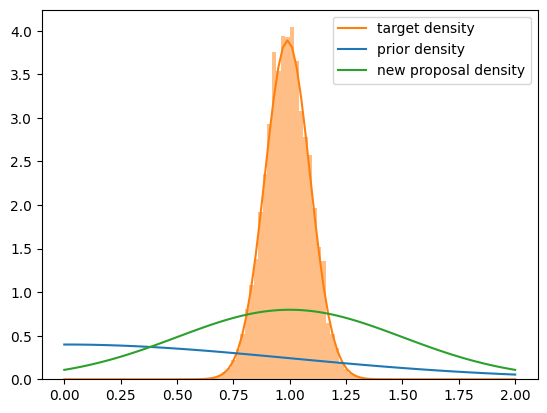

In [11]:
def q():
  x = numpyro.sample("x", dist.Normal(1, 0.5))
  return (x,)


def log_proposal_density(x):
  return dist.Normal(1, 0.5).log_prob(x)


log_extended_proposal_density = lambda x, y: log_proposal_density(
    x
) + log_extend_density(x, y)


f_batch = numpyro.plate("particle_plate", 10000)(f)
q_batch = numpyro.plate("particle_plate", 10000)(q)
q2 = coix.propose(f_batch, q_batch)
_, q2_trace, q2_metrics = traced_evaluate(q2, seed=0)()
_, _, f_batch_metrics = traced_evaluate(f_batch, seed=0)()

approx_target_sampels = q2_trace["x"]["value"]
weights = jnp.exp(q2_metrics["log_weight"])
weights_prior = np.exp(f_batch_metrics["log_weight"])
ess = q2_metrics["ess"]
# ess_prior = jnp.exp(f_batch_metrics["ess"])
print(
    "Variance and ess of importance weight using the prior as a proposal:",
    np.var(weights_prior),
)
print(
    "Variance and ess of importance weight using the new proposal as a"
    " proposal:",
    np.var(weights),
)

plt.plot(
    xrange_target,
    np.exp(normalized_log_target_density(xrange_target)),
    label="target density",
    color="C1",
)
plt.plot(
    xrange_target,
    np.exp(log_prior_density(xrange_target)),
    label="prior density",
    color="C0",
)
plt.plot(
    xrange_target,
    np.exp(log_proposal_density(xrange_target)),
    label="new proposal density",
    color="C2",
)
_ = plt.hist(
    approx_target_sampels,
    weights=weights,
    density=True,
    bins=100,
    range=(xrange_target[0], xrange_target[-1]),
    color="C1",
    alpha=0.5,
)
plt.legend();

We see that the weighted samples generated by `propose(p, q)` approximate the same target density as before. However, the variance of the weights is significantly lower compared to proposing from the program prior.

#### 3. Resample

If we want to generate equally-weighted approximate samples from a target density or discard low-weight samples while maintaining proper weighting we can use the resample combinator. `resample(q)` return a program that first evaluates `q` and then resamples the samples generated by `q` according to their importance weights.

Resampling can be a useful tool that allows us to reallocate particles from low-density regions to high-density regions while maintaining proper weighting and thus to make better use of our overall sampling budget. However, resampling also reduces the sample diversity, as high-weight samples are likely to be reproduced multiple times, which can lead to sample degeneracy. **Hence, resampling should be used with care and it's generably to double-check if the resulting samples suffers from path degeneracy!**

Let's resample our priviouse inference program `q2`:

The log weights after resampling are all equal: [0.06132786 0.06132786 0.06132786 ... 0.06132786 0.06132786 0.06132786]


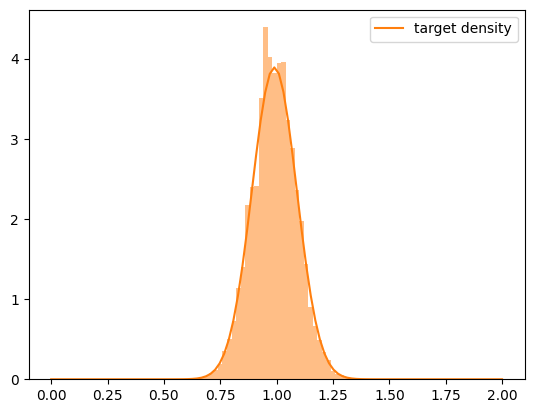

In [12]:
q3 = coix.resample(q2)
_, q3_trace, q3_metrics = traced_evaluate(q3, seed=0)()
approx_target_sampels = q3_trace["x"]["value"]
weights = jnp.exp(q3_metrics["log_weight"])
print("The log weights after resampling are all equal:", weights)

plt.plot(
    xrange_target,
    np.exp(normalized_log_target_density(xrange_target)),
    label="target density",
    color="C1",
)
_ = plt.hist(
    approx_target_sampels,
    weights=weights,
    density=True,
    bins=100,
    range=(xrange_target[0], xrange_target[-1]),
    color="C1",
    alpha=0.5,
)
plt.legend();

#### 4. Compose

We discussed that we can combine primitive programs via function composition in the modeling language or by using `extend` to construct a target programs that make use of auxiliary variables, but there is yet another construct to combine inference programs, `compose`. `compose(q, q')` constructs a new inference program by combining two inference programs, `q` and `q'`. The resulting inference program targets joint target density of both program, while proposing from the joint prior density. 
Similar to function composition, `compose(q, q')` allows arbitrary observe statements in both input programs, `q` and `q'`, and returns the output of the *extending program* `q'` (note that the extending program is the 2nd argument here). 

Let's revisit the extended space example form above, but this time we extend the inference program `q2` instead of `f`. Note that `q2` and `f` have the same target density, but different inference semantics, i.e. they differ in how they generate proposals and compute the corresponding importance weights.

Variance of importance weight of $extend(f, k)$: 0.03914084
Variance of importance weight of $compose(k, q2)$: 0.009500865


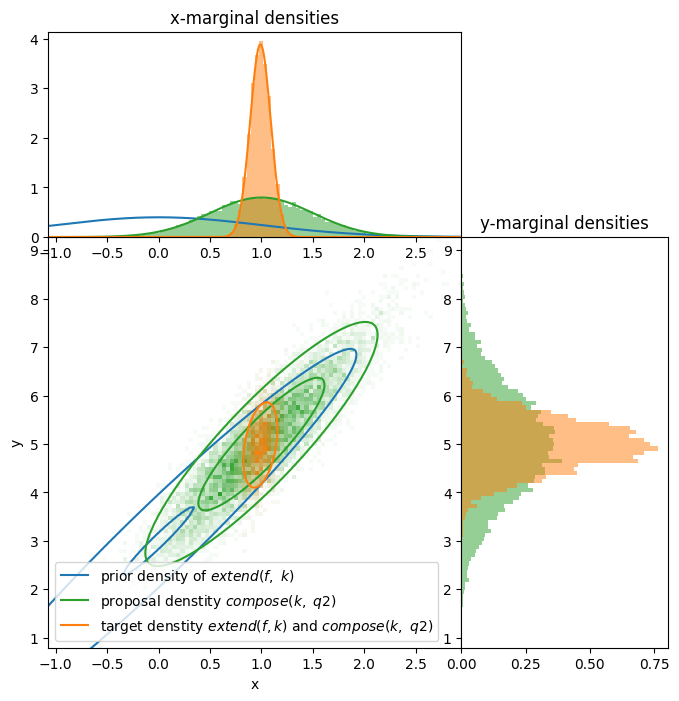

In [13]:
q_com = coix.compose(k, q2)

m_xy = np.dstack(np.meshgrid(xrange_ext, yrange_ext))
m_p_target = np.exp(
    log_extended_target_density(*m_xy.reshape(N_x * N_y, 2).T).reshape(N_y, N_x)
)
m_p_prior = np.exp(
    log_extended_prior_density(*m_xy.reshape(N_x * N_y, 2).T).reshape(N_y, N_x)
)
m_p_proposal = np.exp(
    log_extended_proposal_density(*m_xy.reshape(N_x * N_y, 2).T).reshape(
        N_y, N_x
    )
)

ax_xy, ax_x, ax_y = plot_extended_density_samples(q_com, color1="C2")
ax_x.plot(xrange_prior, np.exp(log_prior_density(xrange_prior)), color="C0")
ax_x.plot(xrange_prior, np.exp(log_proposal_density(xrange_prior)), color="C2")
ax_x.plot(
    xrange_prior,
    np.exp(normalized_log_target_density(xrange_prior)),
    color="C1",
)
ax_xy.contour(
    m_xy[..., 0], m_xy[..., 1], m_p_prior, levels=[0.05, 0.3], colors="C0"
)
ax_xy.contour(
    m_xy[..., 0], m_xy[..., 1], m_p_proposal, levels=[0.05, 0.3], colors="C2"
)
ax_xy.contour(
    m_xy[..., 0], m_xy[..., 1], m_p_target, levels=[0.05, 0.3], colors="C1"
)
handles, labels = ax_xy.get_legend_handles_labels()
handles.extend([
    lines.Line2D(
        [0], [0], label="prior density of $extend(f,\ k)$", color="C0"
    ),
    lines.Line2D(
        [0], [0], label="proposal denstity $compose(k,\ q2)$", color="C2"
    ),
    lines.Line2D(
        [0],
        [0],
        label="target denstity $extend(f, k)$ and $compose(k,\ q2)$",
        color="C1",
    ),
])
ax_xy.legend(handles=handles, loc="lower left")

_, f_ext_trace, f_ext_metrics = traced_evaluate(
    numpyro.plate("particle_plate", 10000)(p_ext), seed=0
)()
_, _, q_com_metrics = traced_evaluate(q_com, seed=0)()
w_ext = np.exp(f_ext_metrics["log_weight"])
w_com = np.exp(q_com_metrics["log_weight"])
print("Variance of importance weight of $extend(f, k)$:", np.var(w_ext))
print("Variance of importance weight of $compose(k, q2)$:", np.var(w_com))

Extending the inference program `q2` instead of the primitive program `f`, results in better coverage of the extended target density, as `q1` uses `q` as a proposal instead of the program prior of `f`. This is again reflected in the variance of the importance weights. Note that the variances are exactly the same as for the non-extended example above. This is because we extended/composed our programs with a kernel program `k`, which does not have any observe statements (and we use the same random seed). As a consequence the prior and target density of the kernel program are the same and cancel out of the final importance weight.

##### Why not always use `propose`? Isn't it just a more flexible version of `extend`?
The answer is yes, but this flexibility comes with a caveat. We are not allowed to use programs constructed by a compose combinator as target programs in later computations. The same is true for any other inference program that is not itself a target program. On a high level, this is because inference programs might represent empirical densities, i.e. degenerate densities that are represented by a set of weighted particles only. As a result we need to be careful how we compose such programs. This is why it's important to follow the rules of the grammar (unless we know exatcly what you are doing)!


### Takeaway

We are now ready to start combining programs using inference combinators and as long as we follow the rules of the grammar the resulting programs are valid, in the sense that they produce propoerly weighted sampels for the target densities they define.

To ensure that all evaluations are properly weighted, more general programs are more restricted in the ways they can be combined with other programs. If in doubt, check the grammar!

As we have seen in the [first tutorial](./tutorial_part1_vae.ipynb), programs can also depend on additional parameter, which can be optimized via stochastic gradient descent. To this end the propose combinator provides a convinient option to compute a loss at every importance sampling step by passing the `loss_fn` argument to the propose combinator.

We demonstrate how inference combinators can be used to compose and train a complex model using a SMC-sampler that samples along a geometric annealing path in the [third tutorial](./tutorial_part3_smcs.ipynb). 